In [8]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.transforms import Compose
from tqdm import tqdm
import mlflow.pytorch
import imgaug.augmenters as iaa
from pprint import pprint
import pandas as pd
import cv2

import mlflow

import matplotlib.pyplot as plt
%matplotlib inline

nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

os.chdir('../../')

from src.data import TrainValTestSplitter, MURASubset
from src.data.transforms import GrayScale, Padding, Resize, HistEqualisation, MinMaxNormalization, ToTensor
from src.features.augmentation import Augmentation
from src.models import BottleneckAutoencoder
from src.models.torchsummary import summary
from src import XR_HAND_CROPPED_PATH, MODELS_DIR, MLFLOW_TRACKING_URI, XR_HAND_PATH

## Helper function to get image in right format

In [13]:
size_sample = 20 # set how many image to be analysed

In [15]:
#MLFlow server must be running at port 5001, but default is 5000

client = mlflow.tracking.MlflowClient(MLFLOW_TRACKING_URI)
client.list_experiments()

[<Experiment: artifact_location='./mlruns/0', experiment_id='0', lifecycle_stage='active', name='Default'>]

In [16]:
run_id = '850f48763e2745f282afb942465b71e5'
experiment = client.get_experiment('1')
path = f'{experiment.artifact_location}/{run_id}/artifacts/baseline_autoencoder_aug/data/model.pth'
path
path_csv = f'{experiment.artifact_location}/{run_id}/artifacts/baseline_autoencoder_aug/data/evaluate_aug_1.csv'
path_loss = f'{experiment.artifact_location}/{run_id}/artifacts/baseline_autoencoder_aug/data/losses_aug_1_2.csv'

2019/06/30 09:06:48 ERROR mlflow.utils.rest_utils: API request to http://localhost:5000/api/2.0/preview/mlflow/experiments/get failed with code 500 != 200, retrying up to 2 more times. API response body: {"error_code": "RESOURCE_DOES_NOT_EXIST", "message": "Could not find experiment with ID 1"}
2019/06/30 09:06:51 ERROR mlflow.utils.rest_utils: API request to http://localhost:5000/api/2.0/preview/mlflow/experiments/get failed with code 500 != 200, retrying up to 1 more times. API response body: {"error_code": "RESOURCE_DOES_NOT_EXIST", "message": "Could not find experiment with ID 1"}
2019/06/30 09:06:54 ERROR mlflow.utils.rest_utils: API request to http://localhost:5000/api/2.0/preview/mlflow/experiments/get failed with code 500 != 200, retrying up to 0 more times. API response body: {"error_code": "RESOURCE_DOES_NOT_EXIST", "message": "Could not find experiment with ID 1"}


MlflowException: API request to http://localhost:5000/api/2.0/preview/mlflow/experiments/get failed to return code 200 after 3 tries

# 1. Augmentation: 5 different augmentation, 1000 Epoch

## 1.1 Get model

In [17]:
splitter = TrainValTestSplitter() 

run_params = {
    'batch_size': 32,
    'image_resolution': (512, 512),
    'num_epochs': 500,
    'batch_normalisation': True,
    'pipeline': {
        'hist_equalisation': True,
        'cropped': False,
    }
}

composed_transforms = Compose([GrayScale(),
                               Padding(),
                               Resize(run_params['image_resolution']),
                               HistEqualisation(active=run_params['pipeline']['hist_equalisation']),
                               MinMaxNormalization(),
                               ToTensor()])

validation = MURASubset(filenames=splitter.data_val.path, true_labels=splitter.data_val.label,
                        patients=splitter.data_val.patient, transform=composed_transforms)

data_path = XR_HAND_CROPPED_PATH if run_params['pipeline']['cropped'] else XR_HAND_PATH

num_workers = 6

device = "cpu"
model = torch.load(path, map_location=lambda storage, loc: storage)

outer_loss = nn.MSELoss(reduction='none')
model.eval().to(device)

=================Train subset=================
Size: 2846
Percentage from original data: 0.5134403752480606
Percentage of negatives: 1.0
Number of patients: 1017
=============Validation subset===============
Size: 1356
Percentage from original data: 0.24463287028684827
Percentage of negatives: 0.4837758112094395
Number of patients: 473
=================Test subset=================
Size: 1341
Percentage from original data: 0.2419267544650911
Percentage of negatives: 0.4153616703952274
Number of patients: 474


NameError: name 'path' is not defined

In [18]:
composed_transforms = Compose([GrayScale(),
                               Padding(max_shape=(750, 750)),  # max_shape - max size of image after augmentation
                               Resize(run_params['image_resolution']),
                               HistEqualisation(active=run_params['pipeline']['hist_equalisation']),
                               MinMaxNormalization(),
                               ToTensor()])

# Dataset loaders
print(f'\nDATA SPLIT:')
splitter = TrainValTestSplitter(path_to_data=data_path)
validation = MURASubset(filenames=splitter.data_val.path, true_labels=splitter.data_val.label,
                        patients=splitter.data_val.patient, transform=composed_transforms)

val_loader = DataLoader(validation, batch_size=run_params['batch_size'], shuffle=True, num_workers=num_workers)


DATA SPLIT:
=================Train subset=================
Size: 2846
Percentage from original data: 0.5134403752480606
Percentage of negatives: 1.0
Number of patients: 1017
=============Validation subset===============
Size: 1356
Percentage from original data: 0.24463287028684827
Percentage of negatives: 0.4837758112094395
Number of patients: 473
=================Test subset=================
Size: 1341
Percentage from original data: 0.2419267544650911
Percentage of negatives: 0.4153616703952274
Number of patients: 474


## 1.2 Get data frame with losses and images from the last validation

In [19]:
augmentation_df_1 = pd.read_csv(path_csv)
print(augmentation_df_1)

NameError: name 'path_csv' is not defined

### 1.2.1 False Negative

In [20]:
false_negative = augmentation_df_1[augmentation_df_1['True label'] == 1].nsmallest(size_sample, 'Loss')
false_negative.style.set_properties(subset=['File name'], **{'width': '300px'})

NameError: name 'augmentation_df_1' is not defined

In [21]:
files_false_negative_path = [x[3:] for x in false_negative['File name'] ]
files_false_negative = MURASubset(filenames=files_false_negative_path, transform=composed_transforms)

NameError: name 'false_negative' is not defined

NameError: name 'files_false_negative' is not defined

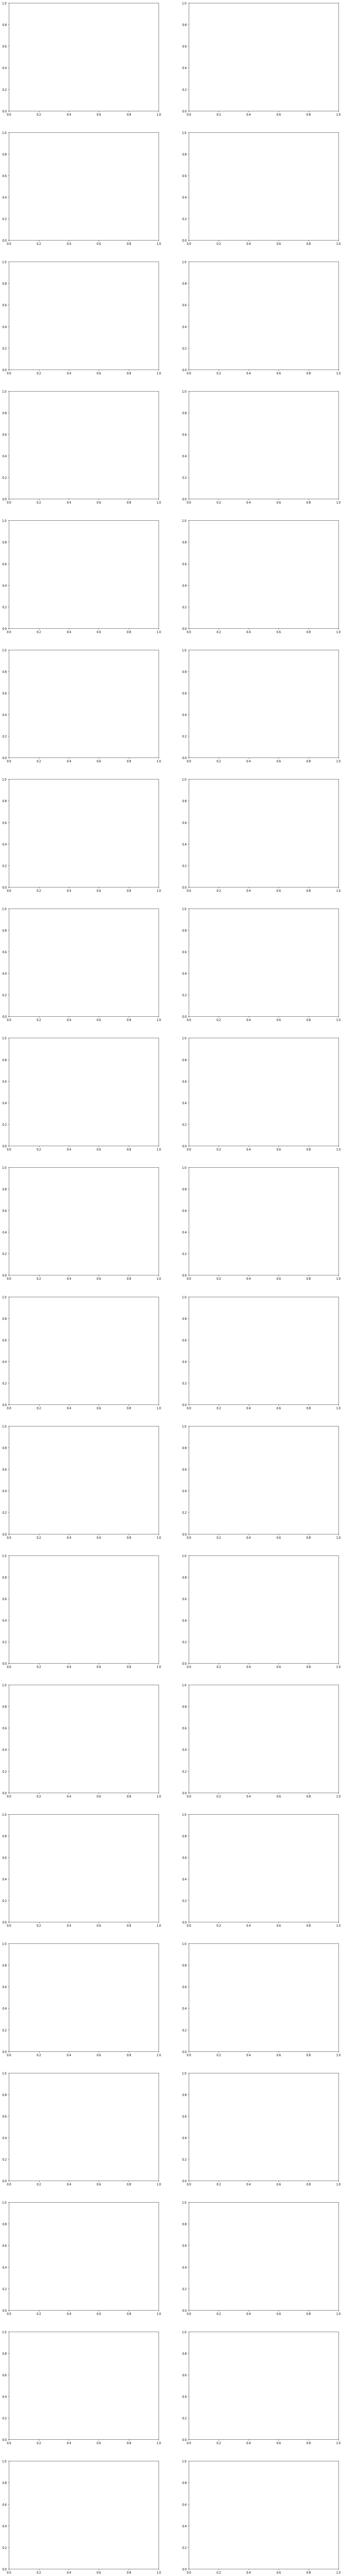

In [22]:
fig, ax = plt.subplots(nrows=size_sample, ncols=2, figsize=(20, 8*size_sample))

for i in range(size_sample):
    image_inp = files_false_negative[i]['image'][None,:,:,:]
    inp = image_inp.to(device)
    output = model(inp)
    
    ax[i, 0].imshow(image_inp.numpy()[0, 0, :, :], cmap='gray', vmin=0, vmax=1)
    ax[i, 1].imshow(output.detach().numpy()[0, 0, :, :], cmap='gray', vmin=0, vmax=1)

### 1.2.2 True Negative

In [ ]:
true_negative = augmentation_df_1[augmentation_df_1['True label'] == 0].nsmallest(size_sample, 'Loss')
true_negative.style.set_properties(subset=['File name'], **{'width': '300px'})


In [ ]:
files_true_negative_path = [x[3:] for x in true_negative['File name'] ]
files_true_negative = MURASubset(filenames=files_true_negative_path, transform=composed_transforms)

In [ ]:
fig, ax = plt.subplots(nrows=size_sample, ncols=2, figsize=(20, 8*size_sample))

for i in range(size_sample):
    image_inp = files_true_negative[i]['image'][None,:,:,:]
    inp = image_inp.to(device)
    output = model(inp)
    
    ax[i, 0].imshow(image_inp.numpy()[0, 0, :, :], cmap='gray', vmin=0, vmax=1)
    ax[i, 1].imshow(output.detach().numpy()[0, 0, :, :], cmap='gray', vmin=0, vmax=1)

### 1.2.3 False Positive

In [15]:
false_positive = augmentation_df_1[augmentation_df_1['True label'] == 0].nlargest(size_sample, 'Loss')
false_positive.style.set_properties(subset=['File name'], **{'width': '300px'})

In [16]:
files_false_positive_path = [x[3:] for x in false_positive['File name'] ]
files_false_positive = MURASubset(filenames=files_false_positive_path, transform=composed_transforms)

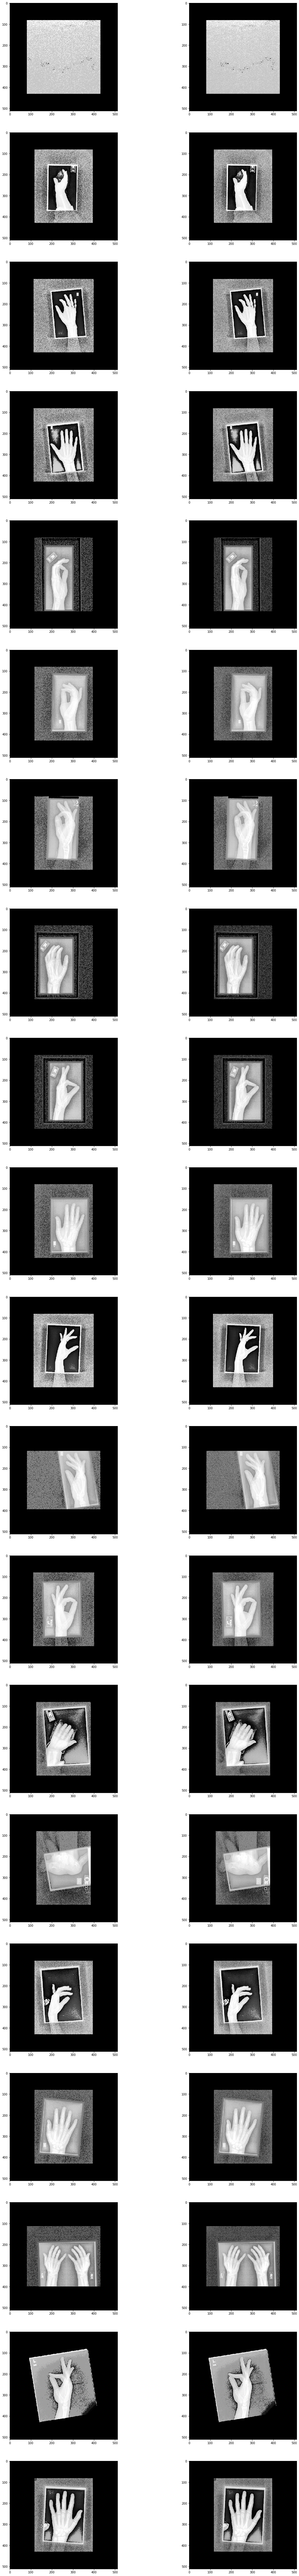

In [17]:
fig, ax = plt.subplots(nrows=size_sample, ncols=2, figsize=(20, 8*size_sample))

for i in range(size_sample):
    image_inp = files_false_positive[i]['image'][None,:,:,:]
    inp = image_inp.to(device)
    output = model(inp)
    
    ax[i, 0].imshow(image_inp.numpy()[0, 0, :, :], cmap='gray', vmin=0, vmax=1)
    ax[i, 1].imshow(output.detach().numpy()[0, 0, :, :], cmap='gray', vmin=0, vmax=1)

The images are missclassified because of:
 - black image without any hand
 - a lot of noise around the hand
 - complex labels that can not be reconstructed
 - some images have more rectangels around the hand
 - wired view on hand
 - hand in motion
 - brighness

### 1.2.4 True Positive

In [18]:
true_positive = augmentation_df_1[augmentation_df_1['True label'] == 1].nlargest(size_sample, 'Loss')
true_positive.style.set_properties(subset=['File name'], **{'width': '300px'})

In [19]:
files_true_positive_path = [x[3:] for x in true_positive['File name'] ]
files_true_positive = MURASubset(filenames=files_true_positive_path, transform=composed_transforms)

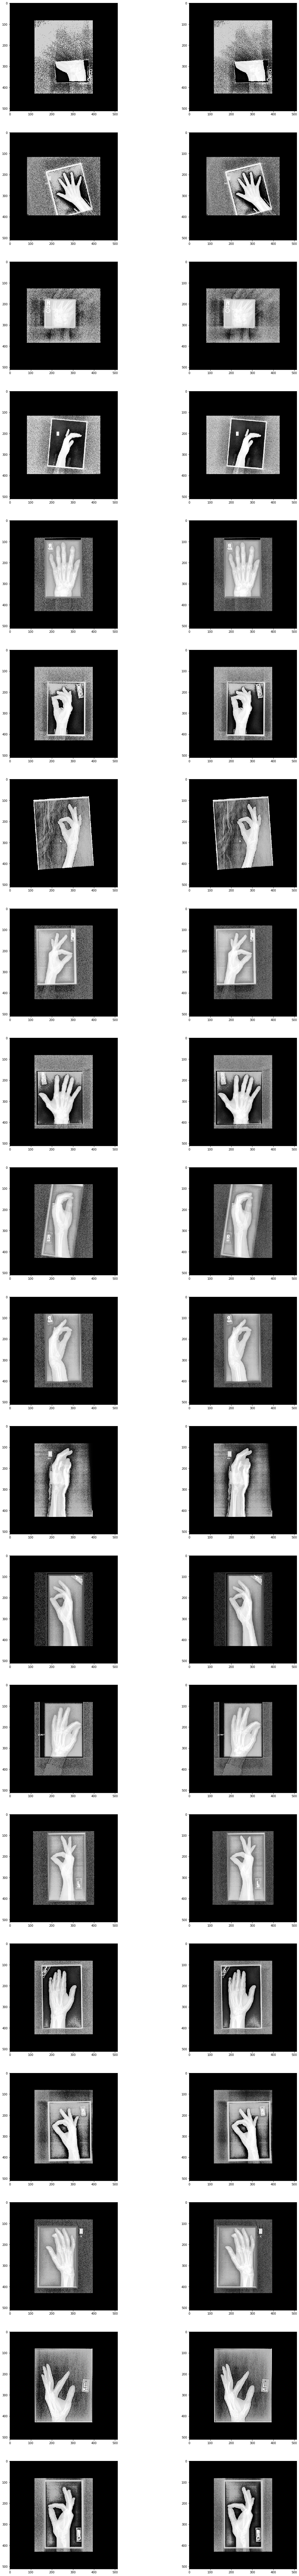

In [20]:
fig, ax = plt.subplots(nrows=size_sample, ncols=2, figsize=(20, 8*size_sample))

for i in range(size_sample):
    image_inp = files_true_positive[i]['image'][None,:,:,:]
    inp = image_inp.to(device)
    output = model(inp)
    
    ax[i, 0].imshow(image_inp.numpy()[0, 0, :, :], cmap='gray', vmin=0, vmax=1)
    ax[i, 1].imshow(output.detach().numpy()[0, 0, :, :], cmap='gray', vmin=0, vmax=1)

## 1.3 Loss per Epoch

In [21]:
augmentation_df_loss_1 = pd.read_csv(path_loss)
print(augmentation_df_loss_1)

     Unnamed: 0     train  validation
0             0  0.025784    0.030342
1             1  0.010477    0.015100
2             2  0.008600    0.011564
3             3  0.007427    0.009389
4             4  0.008045    0.008940
5             5  0.006131    0.008068
6             6  0.005852    0.007600
7             7  0.005083    0.007100
8             8  0.004820    0.006758
9             9  0.004974    0.006738
10           10  0.005544    0.006571
11           11  0.004358    0.006305
12           12  0.005230    0.006156
13           13  0.003996    0.005891
14           14  0.004495    0.005903
15           15  0.003484    0.005802
16           16  0.004114    0.005921
17           17  0.004167    0.005508
18           18  0.005119    0.006785
19           19  0.003524    0.005228
20           20  0.003455    0.005333
21           21  0.003772    0.005147
22           22  0.003827    0.005397
23           23  0.003661    0.005044
24           24  0.003308    0.005103
25          

Text(0.5, 1.0, 'Loss Augmentation: Flip')

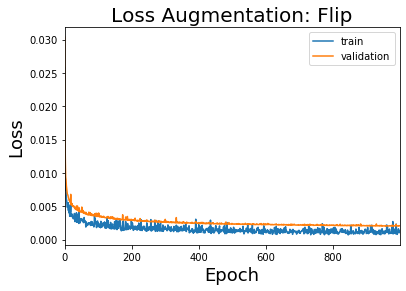

In [22]:
fig = augmentation_df_loss_1.plot.line(x = 'Unnamed: 0',
                                       y = ['train', 'validation'])
fig.set_xlabel('Epoch', fontsize=18)
fig.set_ylabel('Loss', fontsize=18)
fig.set_title('Loss Augmentation: Flip', fontsize=20)

The model seems not to overfit at 1000 epochs. It looks like the loss is still decreasing with some outliers.